In [38]:
%pip install nltk
%pip install tweepy
%pip install pandas
%pip install wordcloud
%pip install textblob
%pip install seaborn
%pip install tensorflow
%pip install sklearn
%pip install zemberek-python
%pip install trnltk
%pip install git+https://github.com/emres/turkish-deasciifier.git
%pip install transformers datasets
%pip install torch
%pip install tensorflow
%pip install pyautogui
%pip install snowballstemmer
%pip install vaderSentiment

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

  Running command git clone --filter=blob:none --quiet https://github.com/emres/turkish-deasciifier.git 'C:\Users\cemke\AppData\Local\Temp\pip-req-build-in95qo8o'


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [39]:
#!/usr/bin/env python
#-*-coding:utf-8-*-
from zemberek import (
    TurkishSpellChecker,
    TurkishSentenceNormalizer,
    TurkishSentenceExtractor,
    TurkishMorphology,
    TurkishTokenizer
)
import pyautogui
import tweepy
import csv
import sys
import time
import re
from tqdm import tqdm
import warnings
import string
import pandas as pd
import ast
import nltk
from snowballstemmer import TurkishStemmer as snowTurkish
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as st
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer
from tweepy import Stream ,OAuthHandler
from tweepy.streaming import Stream
from wordcloud import WordCloud
from textblob import TextBlob
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
from trnlp import TrnlpWord
from trnlp import *
from transformers import AutoModelForSequenceClassification , AutoTokenizer, TextClassificationPipeline, pipeline, AutoModelWithLMHead,AutoModel
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\cemke\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cemke\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cemke\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cemke\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [56]:
class getTweets:
    
    def __init__(self,ckey,csecret,atoken,asecret):
        self.api=None
        self.consumer_key = ckey
        self.consumer_secret = csecret
        self.access_token = atoken
        self.access_token_secret = asecret
        
    def setAuth(self):
        try:
            self.auth = tweepy.OAuthHandler(self.consumer_key, self.consumer_secret)
            self.auth.set_access_token(self.access_token, self.access_token_secret)
            self.api = tweepy.API(self.auth)            
            print ("Bağlantı Yapıldı!")                           
        except tweepy.TweepError as err:
            print('Error: {}'.format(err))   
    
    def toDataFrame(tweets):
        try:
            print ("Veriler Kayıt Ediliyor...")
            pd.set_option('display.max_rows', None)
            pd.set_option('display.max_columns', None)
            pd.set_option('display.width', None)
            pd.set_option('display.max_colwidth', None)
            DataSet = pd.DataFrame()
            
            DataSet['Kullanıcı_Adı'] = [tweet.user.name for tweet in tweets]
            DataSet['Tweet_Tarih'] = [tweet.created_at for tweet in tweets]   
            #DataSet['Tweet_Id'] = [tweet.id for tweet in tweets]
            DataSet['Tweet'] = [tweet.full_text for tweet in tweets]
            #DataSet['Tweet_Degistirilmis'] = [tweet.full_text for tweet in tweets]
            #DataSet['Tweet_Ceviri']=[tweet.full_text for tweet in tweets]            
            #DataSet['Kullanıcı_Id'] = [tweet.user.id for tweet in tweets]  
                
            #DataSet['Dil'] = [tweet.lang for tweet in tweets]
            DataSet.to_csv('Datasets/tw.csv',index=False)
            print ("Veriler Kayıt Edildi!")
            return DataSet
        except Exception as err:
            print('Error: {}'.format(err))
    
    def searchTweet(self,arananTweet):
        self.setAuth()
        try:                      
            print ("Kelimeye Uygun Tweetler Sorgulanıyor...")
            cursor = tweepy.Cursor(self.api.search_tweets, q=arananTweet,result_type="new", lang='tr',tweet_mode="extended")
            results=[]
            for item in cursor.items(150):
                results.append(item)
            print ("Kelimeye Uygun Tweetler Sorgulandı!")
            DataSet = getTweets.toDataFrame(results)            
        except Exception as err:
            print('Error: {}'.format(err))
        finally:
            Dataset=pd.read_csv('Datasets/tw.csv',encoding="utf-8")                   
            getTweets.TweetClear(DataSet)#Tweet Temizlemek için
            getTweets.SentenceNormalization(DataSet)#Türkçe hatalı yazılmış kelimeleri düzeltmek için
            getTweets.TweetTranslate(DataSet)#Tweetleri İngilizceye çevirmek için
            getTweets.EngWordSeparation(DataSet)#İngilizce kelime Stopwords 
            getTweets.TrWordSeparation(DataSet)#Türkçe kelime Stopwords
            getTweets.ToxicSentence(DataSet)#İngilizce Argo cümle bulmak için             
            getTweets.TrStemmed(DataSet)#Türkçe Kelime köklerini almak için
            getTweets.EngStemmed(DataSet)#İngilizce Kelime köklerini almak için
            getTweets.TextblobSentiment(DataSet)#Textblob Duygu Analizi (Kelime pozitif negatif olarak sorguluyor)           
            DataSet.to_csv('Datasets/tw.csv',index=False)

    def TextblobSentiment(DataSet):
        try:
            data=DataSet
            print ("Duygu Analizi Yapılıyor...")            
            data["Tür"] = data["Tweet_Ayrı_Eng"].apply(getTweets.getPolarity)
            data["Yoğunluk"] = data["Tweet_Ayrı_Eng"].apply(getTweets.getSubjectivity)
            data.to_csv('Datasets/textblob_eng_duygu.csv',index=False)
            print("Duygu Analizi Yapıldı!")                        
        except Exception as err:
            print('Error: {}'.format(err)) 
            
    def TweetClear(DataSet):
        try:
            data=DataSet
            print ("Tweetler Temizleniyor...")
            data["Tweet_Clear"]=data["Tweet"]
            pattern = re.compile('http[s]?://(?:[a-zA-Z0-9ğüşöçıİĞÜŞÖÇ]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+|#[a-zA-Z0-9ğüşöçıİĞÜŞÖÇ]+|$[a-zA-ZğüşöçıİĞÜŞÖÇ]+|@[a-zA-Z0-9ğüşöçıİĞÜŞÖÇ_]+|[,.^_$*%-;鶯!?’"“”:=|…#]+|\n+|amp[\s]+|gt;')
            for index in range(len(data["Tweet_Clear"])):        
                data["Tweet_Clear"][index]=pattern.sub(' ', data["Tweet_Clear"][index])    
                data["Tweet_Clear"][index]=data["Tweet_Clear"][index].lower()              
            data["Tweet_Clear"]=data["Tweet_Clear"].str.replace("[^\w\s]","")
            print ("Tweetler Temizlendi!")
            return data
        except Exception as err:
            print('Error: {}'.format(err))  
                              
    def TweetTranslate(DataSet):
        try:
            data=DataSet
            print ("Tweetler Çeviriliyor...")
            data["Tweet_Eng"]=data["Tweet_Clear"]
            for index in range(len(data["Tweet_Eng"])):
                Ceviri_Blob=TextBlob(data["Tweet_Eng"][index])
                Eng_Blob=Ceviri_Blob.translate(from_lang='tr', to='en')  
                data["Tweet_Eng"][index]=Eng_Blob  
                data["Tweet_Eng"][index]=data["Tweet_Eng"][index].lower()
            print ("Tweetler Çevirildi!")                      
            return data      
        except Exception as err:
            print('Error: {}'.format(err)) 
            
    def SentenceNormalization(DataSet):
        try:
            data=DataSet
            print("Cümle Normalizasyonu Yapılıyor...")
            morphology = TurkishMorphology.create_with_defaults()
            normalizer = TurkishSentenceNormalizer(morphology)
            for index in range(len(data["Tweet_Clear"])):                
                data["Tweet_Clear"][index]= normalizer.normalize(data["Tweet_Clear"][index].lower())
            print("Cümle Normalizasyonu Yapıldı!")
            return data
        except Exception as err:
            print('Error: {}'.format(err))
            
    def TrWordSeparation(DataSet):
        try:
            data=DataSet
            print("Türkçe Kelime Ayrıştırma Yapılıyor...")
            data["Tweet_Ayrı_TR"]=data["Tweet_Clear"]
            for index in range(len(data["Tweet_Ayrı_TR"])):
                data["Tweet_Ayrı_TR"][index] = simple_token(data["Tweet_Ayrı_TR"][index], sw=stopwords)
            data["Tweet_Ayrı_TR"] = data["Tweet_Ayrı_TR"].str.join(" ")
            print("Türkçe Kelime Ayrıştırma Yapıldı!")
            return data
        except Exception as err:
            print('Error: {}'.format(err))  
                  
    def EngWordSeparation(DataSet):
        try:
            data=DataSet
            print("İngilizce Kelime Ayrıştırma Yapılıyor...")
            additional  = ['sq','gt','mk','aq','qq','amk']
            stop = st.words('english')
            
            data["Tweet_Ayrı_Eng"] = data["Tweet_Eng"].str.split()           
            data["Tweet_Ayrı_Eng"] = data["Tweet_Ayrı_Eng"].apply(lambda x: [item for item in x if item not in stop])
            data["Tweet_Ayrı_Eng"] = data["Tweet_Ayrı_Eng"].apply(lambda x: [item for item in x if item not in additional])
            data["Tweet_Ayrı_Eng"] = data["Tweet_Ayrı_Eng"].str.join(" ")
            print("İngilizce Kelime Ayrıştırma Yapıldı!")
            return data
        except Exception as err:
            print('Error: {}'.format(err))
            
    def TrStemmed(DataSet):
        try:
            data=DataSet
            data["TR_Kök"] = data["Tweet_Ayrı_TR"]
            # Kök Bulma
            stemmer = snowTurkish()

            stemmed_lists = []
            for index in tqdm(data["TR_Kök"].index):
                mini_l = []
                for text in data.loc[index]["TR_Kök"].split(" "):
                    mini_l.append(stemmer.stemWord(text))

                big_text=" "
                for char in mini_l:
                    big_text = big_text + " " + char
                stemmed_lists.append(big_text)
    
            DataSet['TR_Kök'] = stemmed_lists
            return data
        except Exception as err:
            print('Error: {}'.format(err))
            
    def EngStemmed(DataSet):
        try:
            data=DataSet
            data["Eng_Kök"] = data["Tweet_Ayrı_Eng"]
            # Kök Bulma
            stemmer = PorterStemmer()

            stemmed_lists = []
            for index in tqdm(data["Eng_Kök"].index):
                mini_l = []
                for text in data.loc[index]["Eng_Kök"].split(" "):
                    mini_l.append(stemmer.stem(text))

                big_text=" "
                for char in mini_l:
                    big_text = big_text + " " + char
                stemmed_lists.append(big_text)
    
            DataSet['Eng_Kök'] = stemmed_lists
            return data
        except Exception as err:
            print('Error: {}'.format(err))
            
    def ToxicSentence(DataSet):
        try:
            data=DataSet
            print("Toxic Cümle Analizi Yapılıyor...")
            model_path ="martin-ha/toxic-comment-model"
            tokenizer=AutoTokenizer.from_pretrained(model_path)
            model=AutoModelForSequenceClassification.from_pretrained(model_path)
            pipeline=TextClassificationPipeline(model=model, tokenizer=tokenizer)
            data["Tweet_Toxic"]=data["Tweet_Eng"]
            temp=data["Tweet_Clear"]
            for index in range(len(data["Tweet_Toxic"])):
                sonuc=pipeline(str(data["Tweet_Toxic"][index]))
                if sonuc[0]['label']=="toxic":
                    data["Tweet_Toxic"][index]="Toxic"
                else:
                    data["Tweet_Toxic"][index]="Toxic değil"    
            print("Toxic Cümle Analizi Yapıldı!")
            return data  
        except Exception as err:
            print('Error: {}'.format(err))
        
    def getSubjectivity(DataSet):
        try: 
            sub=TextBlob(DataSet).sentiment.subjectivity               
            if sub >=0.75:
                return "%75 - %100"
            elif sub >=0.5 and sub <0.75:
                return "%50 - %75"
            elif sub >=0.25 and sub <0.50:
                return "%25 - %50"
            else:
                return "0 - 25%"
        except Exception as err:
            print('Error: {}'.format(err))
            
    def getPolarity(DataSet):
        try:
            pol=TextBlob(DataSet).sentiment.polarity
            if pol>0.1:
                return "Pozitif"
            elif pol<-0.1:
                return "Negatif"
            else:
                return "Nötr"
        except Exception as err:
            print('Error: {}'.format(err))

In [41]:
tw = getTweets( 
ckey = 'o7qidRODRWm5u07PtAWrCpSqf',
csecret = '1Yn60OYMJl5kRCSM0XQ4Lskxh6hjM4VMz51OdsS6dM9DQuQ4MV',
atoken = '1315792402234441730-Dt7AydgVGYI5VN9RRQfnR8Endh0WAc',
asecret = 'jhfiDfB53Z27EqHfvfKbNdo0w2SWLqyyoAkILqgSoaGMK'
)
while True:
    aramaTuru=pyautogui.confirm('Ne Tür Bir Arama Yapacaksınız?',title='Arama Türü', buttons=['Hastag','Kelime','Kullanıcı'])
    if aramaTuru=="Hastag":
        arananKelime=pyautogui.prompt(text="Aranacak Kelimeyi Girin:", title='Aranacak Kelime' , default='python')
        temp=("#"+arananKelime+" -filter:retweets")
        tw.searchTweet(arananTweet=temp)
        secim=pyautogui.confirm(text='Tekrar Denemek İster Misiniz?', title='Hata', buttons=["Tekrar","İptal"])
        if secim=="Tekrar":
            continue
        else:
            break
    elif aramaTuru=='Kelime':
        arananKelime=pyautogui.prompt(text="Aranacak Kelimeyi Girin:", title='Aranacak Kelime' , default='python')
        temp=(arananKelime+" -filter:retweets")
        tw.searchTweet(arananTweet=temp)
        secim=pyautogui.confirm(text='Tekrar Denemek İster Misiniz?', title='Hata', buttons=["Tekrar","İptal"])
        if secim=="Tekrar":
            continue
        else:
            break
    elif aramaTuru=='Kullanıcı':
        arananKelime=pyautogui.prompt(text="Aranacak Kelimeyi Girin:", title='Aranacak Kelime' , default='python')
        temp=("@"+arananKelime+" -filter:retweets")
        tw.searchTweet(temp)
        secim=pyautogui.confirm(text='Tekrar Denemek İster Misiniz?', title='Hata', buttons=["Tekrar","İptal"])
        if secim=="Tekrar":
            continue
        else:
            break
    else:
        secim=pyautogui.confirm(text='Hatalı Seçim Yaptınız Tekrar Denemek İster Misiniz?', title='Hata', buttons=["Tekrar","Kapat"])
        if secim=="Tekrar":
            continue
        else:
            break


Bağlantı Yapıldı!
Kelimeye Uygun Tweetler Sorgulanıyor...
Kelimeye Uygun Tweetler Sorgulandı!
Veriler Kayıt Ediliyor...
Veriler Kayıt Edildi!
Tweetler Temizleniyor...
Tweetler Temizlendi!
Cümle Normalizasyonu Yapılıyor...
2023-01-16 07:29:29,814 - zemberek.morphology.turkish_morphology - INFO
Msg: TurkishMorphology instance initialized in 9.963012933731079

Cümle Normalizasyonu Yapıldı!
Tweetler Çeviriliyor...
Tweetler Çevirildi!
İngilizce Kelime Ayrıştırma Yapılıyor...
İngilizce Kelime Ayrıştırma Yapıldı!
Türkçe Kelime Ayrıştırma Yapılıyor...
Türkçe Kelime Ayrıştırma Yapıldı!
Toxic Cümle Analizi Yapılıyor...
Toxic Cümle Analizi Yapıldı!


100%|██████████| 150/150 [00:00<00:00, 3571.67it/s]


Duygu Analizi Yapılıyor...
Duygu Analizi Yapıldı!


In [42]:
Veri=pd.read_csv('Datasets/textblob_eng_duygu.csv')
Veri.head(20)

,Kullanıcı_Adı,Tweet_Tarih,Tweet,Tweet_Clear,Tweet_Eng,Tweet_Ayrı_Eng,Tweet_Ayrı_TR,Tweet_Toxic,TR_Kök,Eng_Kök,Tür,Yoğunluk
0,Cicibebece,2023-01-16 04:28:48+00:00,regl sancısından yamularak kahve içen o kız..,regl sancısından yamularak kahve içen o kız,that girl who drinks coffee by glowing from menstrual pain,girl drinks coffee glowing menstrual pain,regl sancısından yamularak kahve içen o kız,Toxic değil,regl sancı yamularak kahve içe o kız,girl drink coffe glow menstrual pain,Nötr,0 - 25%
1,gadevnganger doo,2023-01-16 04:27:45+00:00,#bayrakli şirinyer tamamen dışarıda bırakıldı ve yerine başka bir çay kaşığı kahve https://t.co/ceL7czNRtF,şirinyer tamamen dışarıda bırakıldı ve yerine başka bir çay kaşığı kahve,şirinyer was completely left out and replaced another teaspoon of coffee,şirinyer completely left replaced another teaspoon coffee,şirinyer tamamen dışarıda bırakıldı başka çay kaşığı kahve,Toxic değil,şirinyer tamame dışarı bırakıl başka çay kaşık kahve,şiriny complet left replac anoth teaspoon coffe,Nötr,0 - 25%
2,mahoni,2023-01-16 04:25:50+00:00,eğer ben isteseydim ben dünyanın en büyük aşığı olabilirdim ama işim var kahve içiyorum😀😀😀 https://t.co/oobxwkSPwz,eğer ben isteseydim ben dünyanın en büyük aşığı olabilirdim ama işim var kahve içiyorum,"if i wanted to be the biggest lover in the world, but i have a job, i drink coffee","wanted biggest lover world, job, drink coffee",eğer isteseydim dünyanın büyük aşığı olabilirdim işim kahve içiyorum,Toxic değil,eğer istes dünya büyük aşık olabilir iş kahve içiyor,"want biggest lover world, job, drink coffe",Nötr,0 - 25%
3,𝐄𝐍𝐄𝐒 𝐎𝐑𝐀𝐋 ,2023-01-16 04:25:15+00:00,@kvefsaneleri Biz kırk yıldır ne boşuna kahve içtik ne boşuna acı çektik,biz kırk yıldır ne boşuna kahve içtik ne boşuna acı çektik,"we have neither had coffee in vain for forty years, nor suffered in vain","neither coffee vain forty years, suffered vain",kırk yıldır boşuna kahve içtik boşuna acı çektik,Toxic değil,kırk yıl boş kahve iç boş aç çek,"neither coffe vain forti years, suffer vain",Nötr,0 - 25%
4,zeynep,2023-01-16 04:24:32+00:00,@pvrisgay bence cok lüks ve asiri bi kahvalti bende cogu zaman kahve bile olmuyor,bence çok lüks ve aşırı bir kahvaltı bende çoğu zaman kahve bile olmuyor,i think it is a very luxurious and extreme breakfast most of the time i don't even have coffee,think luxurious extreme breakfast time even coffee,bence lüks aşırı kahvaltı bende zaman kahve olmuyor,Toxic değil,be lüks aşır kahval be zama kahve olmuyor,think luxuri extrem breakfast time even coffe,Negatif,%75 - %100
5,Hasan Cicekci,2023-01-16 04:24:20+00:00,@sergioneer @turkoshitpost Sakin ol knk 5 saniyede dikiyon üstüne su içiyon 10 saniyede bişeyin kalmıyo ama kassıyonuz bu kahve olayını sanki 83717 tuğla taşıyıp alıyon kızı bi tuzlu kahve ney,sakin ol kanka saniyede dikiyorsun üstüne su içiyorsun saniyede bireyin kalmıyor ama kassiyonuz bu kahve olayını sanki tuğla taşıyıp alıyorsun kızı bir tuzlu kahve ney,"calm down, you are sewing in a second, you drink water on it, but there is no individual in a second, but cottage is as if you carry this coffee event as if you take bricks and take a salt coffee.","calm down, sewing second, drink water it, individual second, cottage carry coffee event take bricks take salt coffee.",sakin ol kanka saniyede dikiyorsun üstüne su içiyorsun saniyede bireyin kalmıyor kassiyonuz kahve olayını sanki tuğla taşıyıp alıyorsun kızı tuzlu kahve ney,Toxic değil,sak ol kanka saniye dikiyor üst su içiyor saniye birey kalmıyor kassiyo kahve olay sanki tuk taşıyıp alıyor kız tuzlu kahve ney,"calm down, sew second, drink water it, individu second, cottag carri coffe event take brick take salt coffee.",Nötr,%25 - %50
6,mert ama duruma bağlı,2023-01-16 04:24:03+00:00,"Günaydın rüyamda bahçeliyle yenicumada kahve içiyoduk, bu hafta da saçma geçicek belli oldu",günaydın rüyamda bahçeliyle yenicumada kahve içiyorduk bu hafta da saçma geçecek belli oldu,"good morning, we were drinking coffee in the yenicum with a 

### BERT MODEL

In [43]:
Veri1=pd.read_csv('Datasets/textblob_eng_duygu.csv',usecols=['Tweet','Tür','Yoğunluk','Tweet_Clear'])
# Eğitilmiş Ağırlıkların Yüklenmesi

model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")

sentiment_analysis_pipeline= pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)
sentiment_result=[]
for text in tqdm(Veri1["Tweet_Clear"]):
    result = sentiment_analysis_pipeline(text)[0]
    sentiment_result.append(result)
        
sentiment_result = pd.DataFrame(sentiment_result)
tweets = pd.concat([Veri1,sentiment_result],axis=1)
tweets.label = tweets.label.map({'positive':'Pozitif','negative':'Negatif'})
tweets.to_csv("Datasets/Bert_Tr_Sonuc.csv",index=False)

Veri2=pd.read_csv("Datasets/Bert_Tr_Sonuc.csv")
Veri2.head()

100%|██████████| 150/150 [00:05<00:00, 26.50it/s]


,Tweet,Tweet_Clear,Tür,Yoğunluk,label,score
0,regl sancısından yamularak kahve içen o kız..,regl sancısından yamularak kahve içen o kız,Nötr,0 - 25%,Negatif,0.995374
1,#bayrakli şirinyer tamamen dışarıda bırakıldı ve yerine başka bir çay kaşığı kahve https://t.co/ceL7czNRtF,şirinyer tamamen dışarıda bırakıldı ve yerine başka bir çay kaşığı kahve,Nötr,0 - 25%,Negatif,0.999148
2,eğer ben isteseydim ben dünyanın en büyük aşığı olabilirdim ama işim var kahve içiyorum😀😀😀 https://t.co/oobxwkSPwz,eğer ben isteseydim ben dünyanın en büyük aşığı olabilirdim ama işim var kahve içiyorum,Nötr,0 - 25%,Negatif,0.777929
3,@kvefsaneleri Biz kırk yıldır ne boşuna kahve içtik ne boşuna acı çektik,biz kırk yıldır ne boşuna kahve içtik ne boşuna acı çektik,Nötr,0 - 25%,Negatif,0.926829
4,@pvrisgay bence cok lüks ve asiri bi kahvalti bende cogu zaman kahve bile olmuyor,bence çok lüks ve aşırı bir kahvaltı bende çoğu zaman kahve bile olmuyor,Negatif,%75 - %100,Negatif,0.999344


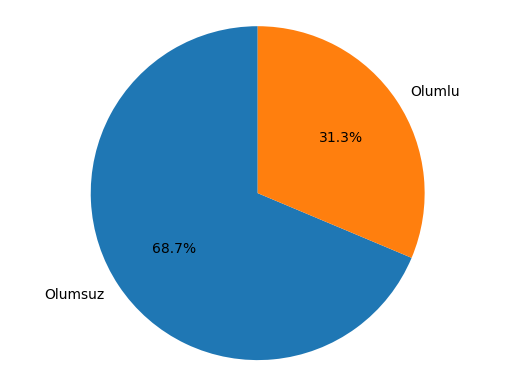

In [44]:
labels = Veri2.label.map({"Pozitif":'Olumlu',"Negatif":'Olumsuz'}).value_counts().index.values
sizes = Veri2.label.value_counts().values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90,explode=None)
ax1.axis('equal')
plt.show()

### ELECTRA (BERT MODEL TABANLI)

In [61]:

Veri1=pd.read_csv('Datasets/textblob_eng_duygu.csv',usecols=['Tweet','Tür','Yoğunluk','Tweet_Clear'])
# Eğitilmiş Ağırlıkların Yüklenmesi

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

model = AutoModel.from_pretrained("dbmdz/bert-base-turkish-cased")

sentiment_analysis_pipeline= pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)
sentiment_result=[]
for text in tqdm(Veri1["Tweet_Clear"]):
    result = sentiment_analysis_pipeline(text)
    sentiment_result.append(result)
        
sentiment_result = pd.DataFrame(sentiment_result)
tweets = pd.concat([Veri1,sentiment_result],axis=1)
tweets.label = tweets.label.map({'positive':'Pozitif','negative':'Negatif'})
tweets.to_csv("Datasets/Bert_Tr_Sonuc2.csv",index=False)

Veri2=pd.read_csv("Datasets/Bert_Tr_Sonuc2.csv")
Veri2.head()

Some weights of the model checkpoint at dbmdz/bert-base-turkish-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
The model 'BertModel' is not supported for sentiment-analysis. Supported models are ['AlbertForSequenceClassifi

KeyError: 'logits'

### Vader Sentiment

In [58]:
sid_obj= SentimentIntensityAnalyzer()
Veri1=pd.read_csv('Datasets/textblob_eng_duygu.csv',usecols=['Tweet','Tür','Yoğunluk','Tweet_Clear','Tweet_Eng','Tweet_Ayrı_Eng'])
sentiment_result=[]
for text in tqdm(Veri1["Tweet_Ayrı_Eng"]):
    result = sid_obj.polarity_scores(text)
    sentiment_result.append(result)
        
sentiment_result = pd.DataFrame(sentiment_result)
tweets = pd.concat([Veri1,sentiment_result],axis=1)
tweets.columns = tweets.columns.map({'pos':'Pozitif','neg':'Negatif','neu':'Nötr','compound':'Yoğunluk'})
tweets.to_csv("Datasets/Vader_Tr_Sonuc.csv",index=False)

Veri2=pd.read_csv("Datasets/Vader_Tr_Sonuc.csv")
Veri2.head(20)

100%|██████████| 150/150 [00:00<00:00, 18757.51it/s]


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Negatif,Nötr,Pozitif,Yoğunluk
0,regl sancısından yamularak kahve içen o kız..,regl sancısından yamularak kahve içen o kız,that girl who drinks coffee by glowing from menstrual pain,girl drinks coffee glowing menstrual pain,Nötr,0 - 25%,0.398,0.602,0.000,-0.5106
1,#bayrakli şirinyer tamamen dışarıda bırakıldı ve yerine başka bir çay kaşığı kahve https://t.co/ceL7czNRtF,şirinyer tamamen dışarıda bırakıldı ve yerine başka bir çay kaşığı kahve,şirinyer was completely left out and replaced another teaspoon of coffee,şirinyer completely left replaced another teaspoon coffee,Nötr,0 - 25%,0.000,0.833,0.167,0.0516
2,eğer ben isteseydim ben dünyanın en büyük aşığı olabilirdim ama işim var kahve içiyorum😀😀😀 https://t.co/oobxwkSPwz,eğer ben isteseydim ben dünyanın en büyük aşığı olabilirdim ama işim var kahve içiyorum,"if i wanted to be the biggest lover in the world, but i have a job, i drink coffee","wanted biggest lover world, job, drink coffee",Nötr,0 - 25%,0.000,0.612,0.388,0.5859
3,@kvefsaneleri Biz kırk yıldır ne boşuna kahve içtik ne boşuna acı çektik,biz kırk yıldır ne boşuna kahve içtik ne boşuna acı çektik,"we have neither had coffee in vain for forty years, nor suffered in vain","neither coffee vain forty years, suffered vain",Nötr,0 - 25%,0.487,0.324,0.189,-0.5673
4,@pvrisgay bence cok lüks ve asiri bi kahvalti bende cogu zaman kahve bile olmuyor,bence çok lüks ve aşırı bir kahvaltı bende çoğu zaman kahve bile olmuyor,i think it is a very luxurious and extreme breakfast most of the time i don't even have coffee,think luxurious extreme breakfast time even coffee,Negatif,%75 - %100,0.000,1.000,0.000,0.0000
5,@sergioneer @turkoshitpost Sakin ol knk 5 saniyede dikiyon üstüne su içiyon 10 saniyede bişeyin kalmıyo ama kassıyonuz bu kahve olayını sanki 83717 tuğla taşıyıp alıyon kızı bi tuzlu kahve ney,sakin ol kanka saniyede dikiyorsun üstüne su içiyorsun saniyede bireyin kalmıyor ama kassiyonuz bu kahve olayını sanki tuğla taşıyıp alıyorsun kızı bir tuzlu kahve ney,"calm down, you are sewing in a second, you drink water on it, but there is no individual in a second, but cottage is as if you carry this coffee event as if you take bricks and take a salt coffee.","calm down, sewing second, drink water it, individual second, cottage carry coffee event take bricks take salt coffee.",Nötr,%25 - %50,0.000,0.881,0.119,0.3182
6,"Günaydın rüyamda bahçeliyle yenicumada kahve içiyoduk, bu hafta da saçma geçicek belli oldu",günaydın rüyamda bahçeliyle yenicumada kahve içiyorduk bu hafta da saçma geçecek belli oldu,"good morning, we were drinking coffee in the yenicum with a garden in my dreams, it would be ridiculous this week.","good morning, drinking coffee yenicum garden dreams, would ridiculous week.",Pozitif,%75 - %100,0.166,0.464,0.371,0.4767
7,"yatarken şunu şunu giyerim, ayağıma da bunu diye uyudum ama ruh halim hiç o kombine uymuyor, kahve elimde başımdaki havlu neredeyse düştü düşecek öyle dolaba bakıyorum",yatarken şunu şunu giyerim ayağıma da bunu diye uyudum ama ruh halim hiç o kombine uymuyor kahve elimde başımdaki havlu neredeyse düştü düşecek öyle dolaba bakıyorum,"i wear this on my feet, but i slept on my feet, but my mood does not fit that combined at all, coffee in my hand, the towel in my head almost falls in the closet, i look at the closet.","wear feet, slept feet, mood fit combined all, coffee hand, towel head almost falls closet, look closet.",Pozitif,%25 - %50,0.000,0.725,0.275,0.6908
8,@Haluk_Yurekli Hava limanında denk gelmiş kahve içiyorlar ne var bunda ve TFF den sadece Hamit var hamite en alt tabakadan zaten sizin yüneticiler kahve ısmarlamasını bilmedikleri için size ters geliyor böyle şeyler,hava limanında denk gelmiş kahve içiyorlar ne var bunda ve tff den sadece hamit var hâmite en alt tabakadan zaten sizin yöneticiler kahve ısmarlamasını bilmedikleri için size ters geliyor böyle şeyler,"they are drinking coffee in the airport, what is there an

In [47]:
Veri3=pd.read_csv('Datasets/textblob_eng_duygu.csv',usecols=['Tweet','Tür','Yoğunluk','Tweet_Clear'])
Veri3["Tür"].value_counts()

Nötr       85
Pozitif    49
Negatif    16
Name: Tür, dtype: int64

<AxesSubplot:xlabel='Tür', ylabel='count'>

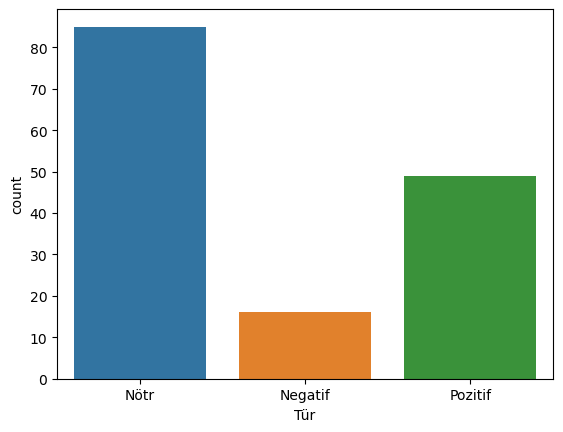

In [48]:
sns.countplot(Veri3["Tür"])

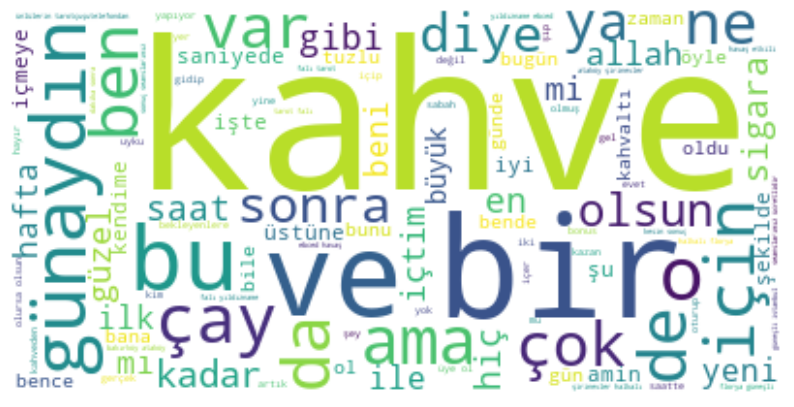

In [49]:
text = " ".join(review for review in Veri3["Tweet_Clear"])
# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [50]:
max_words = 500
max_len= 40

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', Veri3['Tweet_Clear'][0])
X, tokenizer = tokenize_pad_sequences(Veri3['Tweet_Clear'])
print('After Tokenization & Padding \n', X[0])



Before Tokenization & Padding 
 regl sancısından yamularak kahve içen o kız
After Tokenization & Padding 
 [250 251 252   1 253   5 111   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]


In [51]:
vocab_size = tokenizer.document_count

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16),
    tf.keras.layers.LSTM(16, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          2400      
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 4,563
Trainable params: 4,563
Non-trainable params: 0
_________________________________________________________________


In [52]:
y = pd.get_dummies(Veri3['Tür'])
train_data, test_data, train_label, test_label = train_test_split(X, y, test_size=0.10, random_state=42)

print('Train Set ->', train_data.shape, train_label.shape)
print('Test Set ->', test_data.shape, test_label.shape)



Train Set -> (135, 40) (135, 3)
Test Set -> (15, 40) (15, 3)
